### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

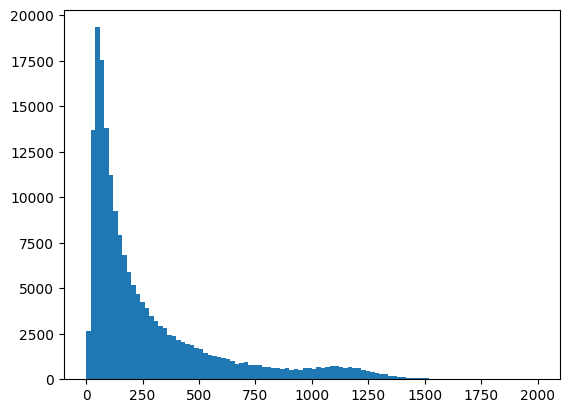

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [8]:
vectorized_texts = vectorize_layer(processed_texts)

In [9]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [12]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 203s 34ms/step - accuracy: 0.9025 - loss: 0.2377 - val_accuracy: 0.9299 - val_loss: 0.1844
Epoch 2/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 205s 35ms/step - accuracy: 0.9412 - loss: 0.1565 - val_accuracy: 0.9371 - val_loss: 0.1659
Epoch 3/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 205s 35ms/step - accuracy: 0.9462 - loss: 0.1428 - val_accuracy: 0.9379 - val_loss: 0.1596
Epoch 4/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 200s 34ms/step - accuracy: 0.9488 - loss: 0.1347 - val_accuracy: 0.9389 - val_loss: 0.1589
Epoch 5/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 203s 35ms/step - accuracy: 0.9517 - loss: 0.1279 - val_accuracy: 0.9392 - val_loss: 0.1596
Epoch 6/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 202s 35ms/step - accuracy: 0.9547 - loss: 0.1202 - val_accuracy: 0.9379 - val_loss: 0.1670
Epoch 7/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 204s 35ms/step - accuracy: 0.9573 - loss: 0.1119 - val_accuracy: 0.9386 - val_loss: 0.1673
Epoch 8/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 201s 35ms/step - accuracy: 

##### Evaluating the Model

In [14]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [15]:
best_model = model
with open('../models/lstm_bi.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [16]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 40)        │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,213 (746.93 KB)

 Trainable params: 63,737 (248.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,476 (497.96 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9429 - loss: 0.1585


In [17]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0563
False Negative Rate: 0.0618
accuracy_score 0.941
precision_score 0.942
recall_score 0.938
f1_score 0.940


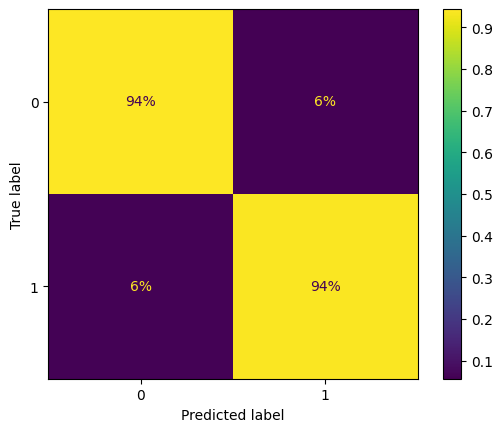

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()